# Predicting Insurance Claims filed by Travelling Agencies

In [1]:
import pandas as pd
import numpy as np
from scipy import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import *
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from collections import Counter

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# import warnings
# from sklearn.exceptions import DataConversionWarning
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# from sklearn.exceptions import FitFailedWarning
# warnings.filterwarnings("ignore", category=FitFailedWarning)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df=pd.read_csv('travel insurance.csv',sep=',')
row,column=df.shape
print("The dataset has {} Rows and {} Columns".format(row,column))
print('')
cols=list(df.columns)
continous=list(set(df._get_numeric_data().columns)-{'Duration','Age'})
print("Columns : ",cols)
print("Continous Variables   : ",continous)
categorical=list(set(cols)-set(continous))
print("Categorical Variables : ",categorical)
# Duration and Age are categorical ( done in EDA part [Ayush_Project.ipynb] )
df_=df.copy()
df_['Gender']=df_['Gender'].fillna('N')

The dataset has 63326 Rows and 11 Columns

Columns :  ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Gender', 'Age']
Continous Variables   :  ['Net Sales', 'Commision (in value)']
Categorical Variables :  ['Claim', 'Duration', 'Agency', 'Age', 'Agency Type', 'Gender', 'Product Name', 'Distribution Channel', 'Destination']


In [5]:
a=list(df_['Destination'].unique())
aa=list(df_['Agency'].unique())

In [6]:
df_ = df_[df_.Age != 118]
df_ = df_[df_.Duration >=0]
df_.loc[df_['Net Sales'] == 0.0, 'Commision (in value)'] = 0
print("Now the dataset  has {} Rows and {} Columns".format(df_.shape[0],df_.shape[1]))
print("%d records deleted from the dataset"%(df.shape[0]-df_.shape[0]))
df_=df_.reset_index().drop(columns='index')
df1=df_.copy()

Now the dataset  has 62342 Rows and 11 Columns
984 records deleted from the dataset


In [7]:
b=list(df_['Destination'].unique())
bb=list(df_['Agency'].unique())

In [8]:
new=[]
for i in a :
  if(i not in list(b)):
    print(i)
    new.append(i)
for i in aa:
  if(i not in list(bb)):
    print(i)
    new.append(i)

KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF
TIBET
JWT


In [9]:
df.loc[df['Destination'].isin(new) ]#| df['Agency'].isin(new)]

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
10,JZI,Airlines,Online,Basic Plan,No,33,"KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF",-26.0,9.1,NaN,118
56265,EPX,Travel Agency,Offline,2 way Comprehensive Plan,No,29,TIBET,24.0,0.0,NaN,118


In [10]:
# Label Encoding
le=LabelEncoder()
le_df=pd.DataFrame()
for i in list(set(df_.columns)-set(df_._get_numeric_data().columns)):
  le_df[i]=le.fit_transform(df_[i])
for j in list(df_._get_numeric_data().columns):
  le_df[j]=df_[j]
print("Label Encoded dataset  has {} Rows and {} Columns".format(le_df.shape[0],le_df.shape[1]))

Label Encoded dataset  has 62342 Rows and 11 Columns


In [11]:
relation=dict()
for l in list(set(df_.columns)-set(df_._get_numeric_data().columns)):
  indx=[]
  for x in df_[l].unique():
    #print(x,' ',df_.index[df_[l] == x].tolist()[0])
    indx.append(df_.index[df_[l] == x].tolist()[0])
  dic=dict(zip(le_df.loc[indx][l].to_list(),df_.loc[indx][l].to_list()))
  relation[l]=dic
  print(dic)

{0: 'No', 1: 'Yes'}
{3: 'CBH', 6: 'CWT', 8: 'JZI', 9: 'KML', 7: 'EPX', 2: 'C2B', 11: 'RAB', 12: 'SSI', 1: 'ART', 5: 'CSR', 4: 'CCR', 0: 'ADM', 10: 'LWC', 14: 'TTW', 13: 'TST'}
{1: 'Travel Agency', 0: 'Airlines'}
{0: 'F', 2: 'N', 1: 'M'}
{12: 'Comprehensive Plan', 16: 'Rental Vehicle Excess Insurance', 25: 'Value Plan', 8: 'Basic Plan', 15: 'Premier Plan', 1: '2 way Comprehensive Plan', 9: 'Bronze Plan', 17: 'Silver Plan', 4: 'Annual Silver Plan', 10: 'Cancellation Plan', 0: '1 way Comprehensive Plan', 22: 'Ticket Protector', 2: '24 Protect', 13: 'Gold Plan', 3: 'Annual Gold Plan', 20: 'Single Trip Travel Protect Silver', 14: 'Individual Comprehensive Plan', 21: 'Spouse or Parents Comprehensive Plan', 7: 'Annual Travel Protect Silver', 19: 'Single Trip Travel Protect Platinum', 5: 'Annual Travel Protect Gold', 18: 'Single Trip Travel Protect Gold', 6: 'Annual Travel Protect Platinum', 11: 'Child Comprehensive Plan', 23: 'Travel Cruise Protect', 24: 'Travel Cruise Protect Family'}
{0: 'O

In [12]:
#OneHotEncoding
ohe=OneHotEncoder()
ohe_df=df_.copy()
for i in list(set(df_.columns)-set(df_._get_numeric_data().columns)-{'Claim'}):
  ohe_df = pd.get_dummies(ohe_df, columns=[i], prefix=[i] )
ohe_df=ohe_df.drop(columns='Claim')
print("One Hot Encoded dataset  has {} Rows and {} Columns".format(ohe_df.shape[0],ohe_df.shape[1]))

One Hot Encoded dataset  has 62342 Rows and 199 Columns


In [13]:
# Function to print the result after the prediction 
def print_result(y_test,y_pred):
  print("Confusion Matrix       : \n" ,confusion_matrix(y_test,y_pred))
  print("Accuracy of Model      : ",accuracy_score(y_test, y_pred))
  print("Precision of Model     : ",precision_score(y_test, y_pred))
  print("Recall of Model        : " , recall_score(y_test, y_pred))
  print("F1 Score of Model      : " ,f1_score(y_test, y_pred))
  print("ROC_AUC score of Model : " ,roc_auc_score(y_test,y_pred))	
  fpr, tpr, thresholds = roc_curve(y_test,y_pred)
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% roc_auc_score(y_test,y_pred))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='best')

In [14]:
# Funtion to print the details after train-test split
def print_input(X_train, X_test, y_train, y_test):
  print("TRAIN(X_train) Feature set        : ",len(X_train))
  print("TRAIN(y_train) Label Feature set  : ",len(y_train))
  print("TEST (X_test)  Feature set        : ",len(X_test))
  print("TEST (y_test)  Label set          : ",len(y_test))
  print("-------For Training Set--------\n")
  print(y_train['Claim'].value_counts())
  l_1,l_2= y_train['Claim'].value_counts()
  print("Class Label 0 is : ",(l_1/y_train.shape[0])*100,"%")
  print("Class Label 1 is : ",(l_2/y_train.shape[0])*100,"%")
  print("\n-------For Testing Set--------\n")
  print(y_test['Claim'].value_counts())
  l_1,l_2= y_test['Claim'].value_counts()
  print("Class Label 0 is : ",(l_1/y_test.shape[0])*100,"%")
  print("Class Label 1 is : ",(l_2/y_test.shape[0])*100,"%")

In [15]:
# Function to balance the imbalanced classes 
def balance(X_train,y_train,typ,s=0.3):
  if(typ.lower() == 'ros'):
    rus=RandomOverSampler(random_state=21)
    x_res, y_res = rus.fit_sample(X_train, y_train)
    print('Dataset shape after Random Over Sampling', Counter(y_res))
    print('After ROS the number of Rows Training set has are  : ', x_res.shape[0])
  elif(typ.lower() == 'rus' ):
    ros=RandomUnderSampler(random_state=21)
    x_res, y_res = ros.fit_sample(X_train, y_train)
    print('Dataset shape after Random Under Sampling', Counter(y_res))
    print('After RUS the number of Rows Training set has are : ', x_res.shape[0])
  elif(typ.lower() == 'adasyn'):
    ada=ADASYN(random_state=21, sampling_strategy=s, n_jobs=-1)
    x_res, y_res = ada.fit_sample(X_train, y_train)
    print('Dataset shape after ADASYN', Counter(y_res))
    print('After ADASYN the number of Rows Training set has are : ', x_res.shape[0])
  elif(typ.lower() == 'smote'):
    smo=SMOTE(random_state=21, sampling_strategy=s, n_jobs=-1)
    x_rs, y_rs = smo.fit_sample(X_train, y_train)
    tom=TomekLinks(random_state=21)
    x_res, y_res = tom.fit_sample(x_rs,y_rs)
    print('Dataset shape after SMOTE + Tomek Links', Counter(y_res))
    print('After SMOTE Tomek the number of Rows Training set has are : ', x_res.shape[0])
  return x_res, y_res


In [16]:
# Function to plot the scatter plot of values it get by applying PCA
def plt_scatter(tmp_sample):
  plt.figure(figsize=(10,10))
  sns.scatterplot(x='Component 1',y='Component 2', hue='Label', data=tmp_sample)
  plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)


In [17]:
# Function to count the number of elements with Label 1 and Lable 0
def plt_print(temp):
  tmp_sample = temp.sample(frac = 0.10, random_state=21)
  tmp_sample = tmp_sample[tmp_sample['Component 1'] < 0.90 ]
  print(tmp_sample['Label'].value_counts())
  l_1,l_2= tmp_sample['Label'].value_counts()
  print("Class Label 0 is : ",(l_1/tmp_sample.shape[0])*100,"%")
  print("Class Label 1 is : ",(l_2/tmp_sample.shape[0])*100,"%")
  print(" ")
  plt_scatter(tmp_sample)

In [18]:
# Function to plot the graph 
def plot_graph(X_train,y_train):
  pca=PCA(n_components=2) 
  dim=pca.fit_transform(X_train)
  scaler=MinMaxScaler()
  res=scaler.fit_transform(dim)
  temp= pd.DataFrame(res,columns=['Component 1', 'Component 2'])
  y_temp=y_train.copy()
  y_temp=y_temp.reset_index()
  temp['Label'] = y_temp['Claim']
  plt_print(temp)

In [19]:
# Function to plot the graph 
def plt_graph(X_train,y_train):
  pca=PCA(n_components=2) 
  dim=pca.fit_transform(X_train)
  scaler=MinMaxScaler()
  res=scaler.fit_transform(dim)
  temp= pd.DataFrame(res,columns=['Component 1', 'Component 2'])
  y_temp=y_train.copy()
  temp['Label'] = y_temp
  plt_print(temp)

In [20]:
# Function to print precision , recall, Accuracy and F1 score
def calc(TP,TN,FP,FN):
  if(TP==0):
    TP=0.00000000000000001
  if(FP==0):
    FP=0.00000000000000001
  if(FN==0):
    FN=0.00000000000000001
  conf_mat=[[TN,FP],[FN,TP]]
  precision=(TP/(TP+FP))
  recall= (TP/(TP+FN))
  f1=((2*recall*precision)/(recall+precision))
  accuracy=((TP+TN)/(TP+TN+FP+FN))
  TPR=(TP/(TP+FN))
  FPR=(FP/(FP+TN))
  print("Confusion Matrix       : \n" ,conf_mat[0],'\n',conf_mat[1])
  print("Accuracy of Model      : ", accuracy)
  print("Precision of Model     : ", precision)
  print("Recall of Model        : ", recall)
  print("F1 Score of Model      : ", f1)

In [21]:
# Function to compute the value of TP, TN, FP, FN
def comp(y_test,y_pred):
  TP=0
  TN=0
  FP=0
  FN=0
  for i in range(0,len(y_pred)):
    if (int(y_test.iloc[i]) == 1 and y_pred[i] == 1):
      TP+=1
    elif (int(y_test.iloc[i]) == 1 and y_pred[i] == 0 ):
      FN+=1
    elif (int(y_test.iloc[i]) == 0 and y_pred[i] == 1 ):
      FP+=1
    elif (int(y_test.iloc[i]) == 0 and y_pred[i] == 0 ):
      TN+=1
  print("{0} {1} {2} {3}".format(TP,TN,FP,FN))
  calc(TP,TN,FP,FN)

In [22]:
# Funtion to get the predicted value via probability 
def thresh(y_thresh,val=0.5):
  y_pred=[]
  for i in range(0,len(y_thresh)):
    if(y_thresh[i][0] >= val):
      y_pred.append(0)
    else:
      y_pred.append(1)
  y_pred=np.array(y_pred)
  return y_pred


In [23]:
# Function to Compare all the four buckets ( TP, TN, FP, FN) of the top 10% imp features
def comp_feat(X_test,y_test,y_pred):
  new=X_test.copy()
  new=new.reset_index()
  new=new.drop(columns='index')
  new['Actual']=y_test.values
  new['Predicted']=y_pred
  for i in range(0,len(new)):
    if   (int(new.iloc[i]['Actual']) == 1 and int(new.iloc[i]['Predicted']) == 1 ):
      new.loc[i,'TP'] = 1
    elif (int(new.iloc[i]['Actual']) == 1 and int(new.iloc[i]['Predicted']) == 0 ):
      new.loc[i,'FN'] = 1
    elif (int(new.iloc[i]['Actual']) == 0 and int(new.iloc[i]['Predicted']) == 1 ):
      new.loc[i,'FP'] = 1
    elif (int(new.iloc[i]['Actual']) == 0 and int(new.iloc[i]['Predicted']) == 0 ):
      new.loc[i,'TN'] = 1
  new=new.fillna(0)
  return(new)  

In [24]:
# Function to Compare all the four buckets ( TP, TN, Fp, FN) of the top 10% imp features
def compp_feat(X_test,y_test,y_pred):
  new=X_test.copy()
  new=new.reset_index()
  new=new.drop(columns='index')
  new['Actual']=y_test.values
  new['Predicted']=y_pred
  for i in range(0,len(new)):
    if   (int(new.iloc[i]['Actual']) == 1 and int(new.iloc[i]['Predicted']) == 1 ):
      new.loc[i,'TP'] = 1
    elif (int(new.iloc[i]['Actual']) == 1 and int(new.iloc[i]['Predicted']) == 0 ):
      new.loc[i,'FN'] = 1
    elif (int(new.iloc[i]['Actual']) == 0 and int(new.iloc[i]['Predicted']) == 1 ):
      new.loc[i,'FP'] = 1
    elif (int(new.iloc[i]['Actual']) == 0 and int(new.iloc[i]['Predicted']) == 0 ):
      new.loc[i,'TN'] = 1
  #new=new.fillna(0)
  return(new)  

In [25]:
# Function to plot the mapping of 4 Buckets 
def plot_buk(val,new_dff):
  nn=[['TP','TN'],['FP','FN']]
  f, axes = plt.subplots(2, 2)
  f.set_size_inches(15,10)
  for i in range(2):
    for j in range(2):
      sns.countplot(x=val,hue=nn[i][j],data=new_dff,ax=axes[i][j])
      sns.countplot(x=val,hue=nn[i][j],data=new_dff,ax=axes[i][j])
      sns.countplot(x=val,hue=nn[i][j],data=new_dff,ax=axes[i][j])
      sns.countplot(x=val,hue=nn[i][j],data=new_dff,ax=axes[i][j])

In [26]:
target = pd.DataFrame(le_df['Claim'])
le_df=le_df.drop(columns='Claim')

# MODEL TRAINING

## Without HyperParameter Tuning

In [27]:
X_train, X_test, y_train, y_test = train_test_split(ohe_df,target,test_size = 0.25, random_state = 21, stratify = target)
print_input(X_train, X_test, y_train, y_test)
X_u_train, y_u_train = balance(X_train, y_train.values.ravel(),'rus')
X_o_train, y_o_train = balance(X_train, y_train.values.ravel(),'ros')
X_s_train, y_s_train = balance(X_train, y_train.values.ravel(),'smote',0.5)
X_a_train, y_a_train = balance(X_train, y_train.values.ravel(),'adasyn',0.5)

TRAIN(X_train) Feature set        :  46756
TRAIN(y_train) Label Feature set  :  46756
TEST (X_test)  Feature set        :  15586
TEST (y_test)  Label set          :  15586
-------For Training Set--------

0    46068
1      688
Name: Claim, dtype: int64
Class Label 0 is :  98.52853109761314 %
Class Label 1 is :  1.4714689023868595 %

-------For Testing Set--------

0    15357
1      229
Name: Claim, dtype: int64
Class Label 0 is :  98.53073270884127 %
Class Label 1 is :  1.4692672911587321 %
Dataset shape after Random Under Sampling Counter({0: 688, 1: 688})
After RUS the number of Rows Training set has are :  1376
Dataset shape after Random Over Sampling Counter({0: 46068, 1: 46068})
After ROS the number of Rows Training set has are  :  92136
Dataset shape after SMOTE + Tomek Links Counter({0: 45752, 1: 23034})
After SMOTE Tomek the number of Rows Training set has are :  68786
Dataset shape after ADASYN Counter({0: 46068, 1: 22899})
After ADASYN the number of Rows Training set has are 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
[0 0 0 ... 0 1 0]
Confusion Matrix       : 
 [[11400  3957]
 [   63   166]]
Accuracy of Model      :  0.7420762222507379
Precision of Model     :  0.040261945185544504
Recall of Model        :  0.7248908296943232
F1 Score of Model      :  0.07628676470588235
ROC_AUC score of Model :  0.7336116582540769


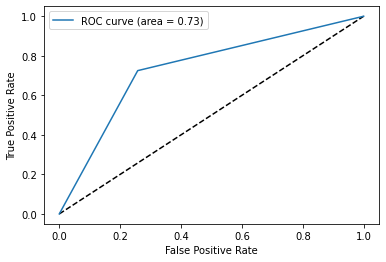

In [28]:
clf_dt = RandomForestClassifier(random_state=42)
clf_dt.fit(X_u_train, y_u_train)
y_pred = clf_dt.predict(X_test)
print(clf_dt)
print(y_pred)
print_result(y_test=y_test,y_pred=y_pred)

In [29]:
scoring = ['accuracy','precision', 'recall','roc_auc']
cv_results = cross_validate(clf_dt, X_u_train, y_u_train, cv=10, scoring=scoring )
cv_results.keys()
cv_results

{'fit_time': array([0.32932901, 0.32929444, 0.33527946, 0.34316635, 0.32997489,
        0.33103967, 0.3243587 , 0.33560014, 0.32243371, 0.33821082]),
 'score_time': array([0.02576637, 0.02489281, 0.02452421, 0.0255959 , 0.02452993,
        0.02461576, 0.02450681, 0.02508235, 0.02603483, 0.02515221]),
 'test_accuracy': array([0.76086957, 0.76086957, 0.80434783, 0.83333333, 0.77536232,
        0.77536232, 0.75182482, 0.75912409, 0.7080292 , 0.78832117]),
 'test_precision': array([0.78125   , 0.79032258, 0.81818182, 0.84848485, 0.76388889,
        0.77142857, 0.77419355, 0.74647887, 0.76363636, 0.79411765]),
 'test_recall': array([0.72463768, 0.71014493, 0.7826087 , 0.8115942 , 0.79710145,
        0.7826087 , 0.70588235, 0.77941176, 0.60869565, 0.7826087 ]),
 'test_roc_auc': array([0.80833858, 0.79762655, 0.82829238, 0.89834068, 0.80277253,
        0.83018273, 0.77227195, 0.81852089, 0.76534527, 0.83898124])}

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85     15357
           1       0.04      0.72      0.08       229

    accuracy                           0.74     15586
   macro avg       0.52      0.73      0.46     15586
weighted avg       0.98      0.74      0.84     15586



In [31]:
np.mean(cv_results['test_recall'])

0.7485294117647059

In [128]:
np.mean(cv_results['test_accuracy'])

0.7717444197609226

In [32]:
cross_val_score(clf_dt, X_u_train, y_u_train, cv=10)

array([0.76086957, 0.76086957, 0.80434783, 0.83333333, 0.77536232,
       0.77536232, 0.75182482, 0.75912409, 0.7080292 , 0.78832117])

In [130]:
np.mean(cross_val_score(clf_dt, X_u_train, y_u_train, cv=10))

0.7710092034274834

## With HyperParameter Tuning

In [33]:
clf_dt = RandomForestClassifier()
param_grid = {
   'max_leaf_nodes': [ 40,50 ],
   'class_weight' : ['balanced'],
   'criterion' :['gini','entropy'] ,
   'max_depth' : [ 30, 50, 100 ],
   'min_samples_split': [ 2, 3, 4]
    }

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=40, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix       : 
 [[12542  2815]
 [   69   160]]
Accuracy of Model      :  0.814962145515206
Precision of Model     :  0.05378151260504202
Recall of Model        :  0.6986899563318777
F1 Score of Model      :  0.09987515605493133
ROC_AUC score of Model :  0.757692962798354


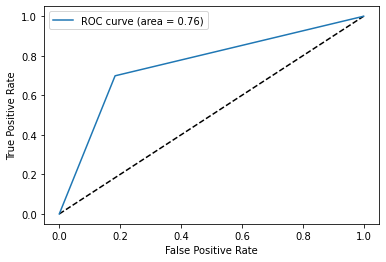

In [34]:
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
CV_dt.fit(X_u_train, y_u_train)
clf_best_dt = CV_dt.best_estimator_
print(clf_best_dt)
y_predd = clf_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_predd)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix       : 
 [[12423  2934]
 [   69   160]]
Accuracy of Model      :  0.8073270884126781
Precision of Model     :  0.051712992889463474
Recall of Model        :  0.6986899563318777
F1 Score of Model      :  0.09629852542882937
ROC_AUC score of Model :  0.7538185081522644


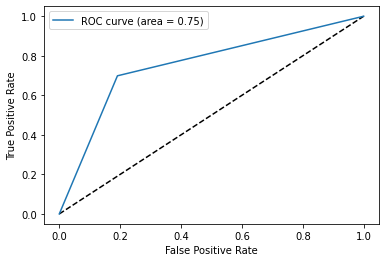

In [35]:
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 10)
CV_dt.fit(X_u_train, y_u_train)
clf_best_ = CV_dt.best_estimator_
print(clf_best_)
y_preddd = clf_best_.predict(X_test)
print_result(y_test=y_test,y_pred=y_preddd)

# Feature Selection 

In [36]:
# hyper parameter 
hyp1=pd.DataFrame({'Percent' : clf_best_dt.feature_importances_ , 'col' : ohe_df.columns}).sort_values(by='Percent',ascending=False)
hyp1[:19]

,Percent,col
2,0.117559,Commision (in value)
6,0.112215,Agency_C2B
1,0.110572,Net Sales
141,0.079958,Destination_SINGAPORE
0,0.070049,Duration
23,0.051389,Gender_N
19,0.048429,Agency Type_Airlines
183,0.047596,Product Name_Cancellation Plan
3,0.044123,Age
20,0.035147,Agency Type_Travel Agency


In [37]:
# hyper parameter 
hyp2=pd.DataFrame({'Percent' : clf_best_.feature_importances_ , 'col' : ohe_df.columns}).sort_values(by='Percent',ascending=False)
hyp2[:19]

,Percent,col
2,0.113492,Commision (in value)
1,0.112008,Net Sales
6,0.101775,Agency_C2B
0,0.085279,Duration
3,0.050587,Age
141,0.049318,Destination_SINGAPORE
23,0.048951,Gender_N
19,0.047018,Agency Type_Airlines
183,0.044811,Product Name_Cancellation Plan
20,0.037945,Agency Type_Travel Agency


In [38]:
# without hyper parameter
clf_dt.fit(X_u_train, y_u_train)
imp=pd.DataFrame({'Percent' : clf_dt.feature_importances_ , 'col' : ohe_df.columns}).sort_values(by='Percent',ascending=False)
imp[:19]

,Percent,col
0,0.193720,Duration
1,0.155386,Net Sales
3,0.129109,Age
2,0.093039,Commision (in value)
6,0.049438,Agency_C2B
141,0.034211,Destination_SINGAPORE
183,0.022613,Product Name_Cancellation Plan
23,0.022052,Gender_N
11,0.019363,Agency_EPX
19,0.018759,Agency Type_Airlines


In [106]:
l=imp['col'][0:19].to_list()
h1=hyp1['col'][0:19].to_list()
h2=hyp2['col'][0:19].to_list()

# Comparing Feature selction for each TP, TN, FP, FN

### With Hyperparameter tuning

In [40]:
h1

['Commision (in value)',
 'Agency_C2B',
 'Net Sales',
 'Destination_SINGAPORE',
 'Duration',
 'Gender_N',
 'Agency Type_Airlines',
 'Product Name_Cancellation Plan',
 'Age',
 'Agency Type_Travel Agency',
 'Agency_EPX',
 'Gender_F',
 'Product Name_Basic Plan',
 'Agency_LWC',
 'Product Name_2 way Comprehensive Plan',
 'Agency_JZI',
 'Product Name_Annual Silver Plan',
 'Gender_M',
 'Product Name_Bronze Plan']

In [41]:
h2

['Commision (in value)',
 'Net Sales',
 'Agency_C2B',
 'Duration',
 'Age',
 'Destination_SINGAPORE',
 'Gender_N',
 'Agency Type_Airlines',
 'Product Name_Cancellation Plan',
 'Agency Type_Travel Agency',
 'Agency_EPX',
 'Gender_F',
 'Agency_JZI',
 'Product Name_Basic Plan',
 'Product Name_Annual Silver Plan',
 'Product Name_2 way Comprehensive Plan',
 'Product Name_Silver Plan',
 'Product Name_Bronze Plan',
 'Destination_MALAYSIA']

In [42]:
new_df=comp_feat(X_test,y_test,y_preddd)

In [107]:
n=['TP','TN','FP','FN','Actual','Predicted']
for i in n:
  h2.append(i)
new_df=new_df[h2]


In [44]:
new_df

,Commision (in value),Net Sales,Agency_C2B,Duration,Age,Destination_SINGAPORE,Gender_N,Agency Type_Airlines,Product Name_Cancellation Plan,Agency Type_Travel Agency,Agency_EPX,Gender_F,Agency_JZI,Product Name_Basic Plan,Product Name_Annual Silver Plan,Product Name_2 way Comprehensive Plan,Product Name_Silver Plan,Product Name_Bronze Plan,Destination_MALAYSIA,TP,TN,FP,FN,Actual,Predicted
0,0.00,20.0,0,21,34,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0,0
1,0.00,24.0,0,47,36,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0,0
2,35.64,-59.4,0,61,60,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
3,0.00,80.0,0,63,36,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
4,0.00,28.0,0,79,36,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15581,0.00,29.0,0,77,36,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0,0
15582,0.00,15.0,0,4,36,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
15583,9.10,26.0,0,40,44,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
15584,18.00,72.0,1,35,39,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0.0,0.0,1.0,0.0,0,1


In [45]:
new_dff=compp_feat(X_test,y_test,y_preddd)

In [46]:
new_dff=new_dff[h2]


In [47]:
new_dff

,Commision (in value),Net Sales,Agency_C2B,Duration,Age,Destination_SINGAPORE,Gender_N,Agency Type_Airlines,Product Name_Cancellation Plan,Agency Type_Travel Agency,Agency_EPX,Gender_F,Agency_JZI,Product Name_Basic Plan,Product Name_Annual Silver Plan,Product Name_2 way Comprehensive Plan,Product Name_Silver Plan,Product Name_Bronze Plan,Destination_MALAYSIA,TP,TN,FP,FN,Actual,Predicted
0,0.00,20.0,0,21,34,0,1,0,0,1,1,0,0,0,0,1,0,0,0,NaN,1.0,NaN,NaN,0,0
1,0.00,24.0,0,47,36,0,1,0,0,1,1,0,0,0,0,1,0,0,0,NaN,1.0,NaN,NaN,0,0
2,35.64,-59.4,0,61,60,0,1,0,0,1,0,0,0,0,0,0,0,0,0,NaN,1.0,NaN,NaN,0,0
3,0.00,80.0,0,63,36,0,1,0,1,1,1,0,0,0,0,0,0,0,0,NaN,1.0,NaN,NaN,0,0
4,0.00,28.0,0,79,36,0,1,0,1,1,1,0,0,0,0,0,0,0,0,NaN,1.0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15581,0.00,29.0,0,77,36,0,1,0,0,1,1,0,0,0,0,1,0,0,0,NaN,1.0,NaN,NaN,0,0
15582,0.00,15.0,0,4,36,0,1,0,1,1,1,0,0,0,0,0,0,0,0,NaN,1.0,NaN,NaN,0,0
15583,9.10,26.0,0,40,44,0,0,1,0,0,0,0,1,1,0,0,0,0,0,NaN,1.0,NaN,NaN,0,0
15584,18.00,72.0,1,35,39,1,0,1,0,0,0,1,0,0,0,0,1,0,0,NaN,NaN,1.0,NaN,0,1


#Graph

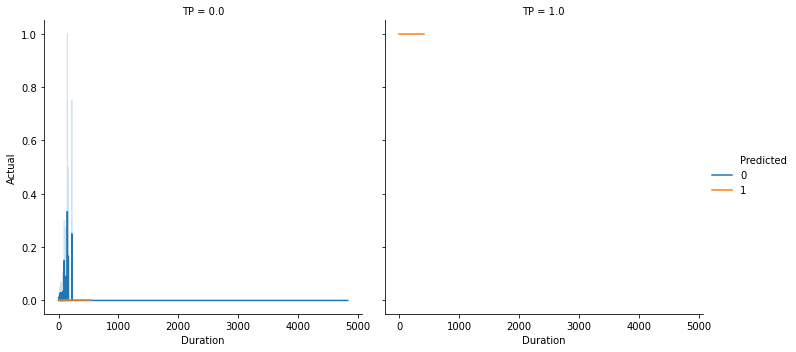

In [123]:
sns.relplot(x="Duration", y="Actual",hue="Predicted", col='TP', kind="line", data=new_df);

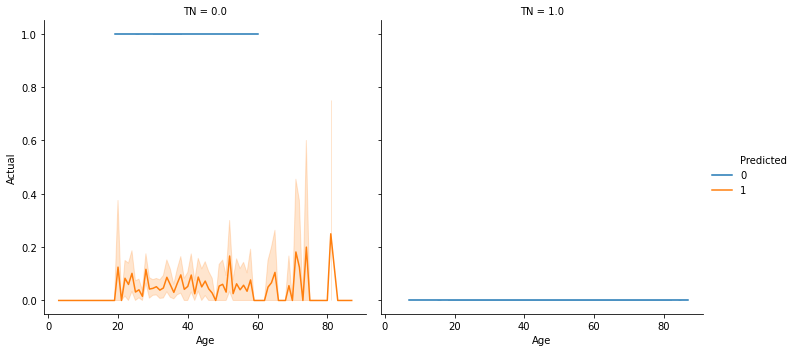

In [125]:
sns.relplot(x="Age", y="Actual",hue="Predicted", col='TN', kind="line", data=new_df);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


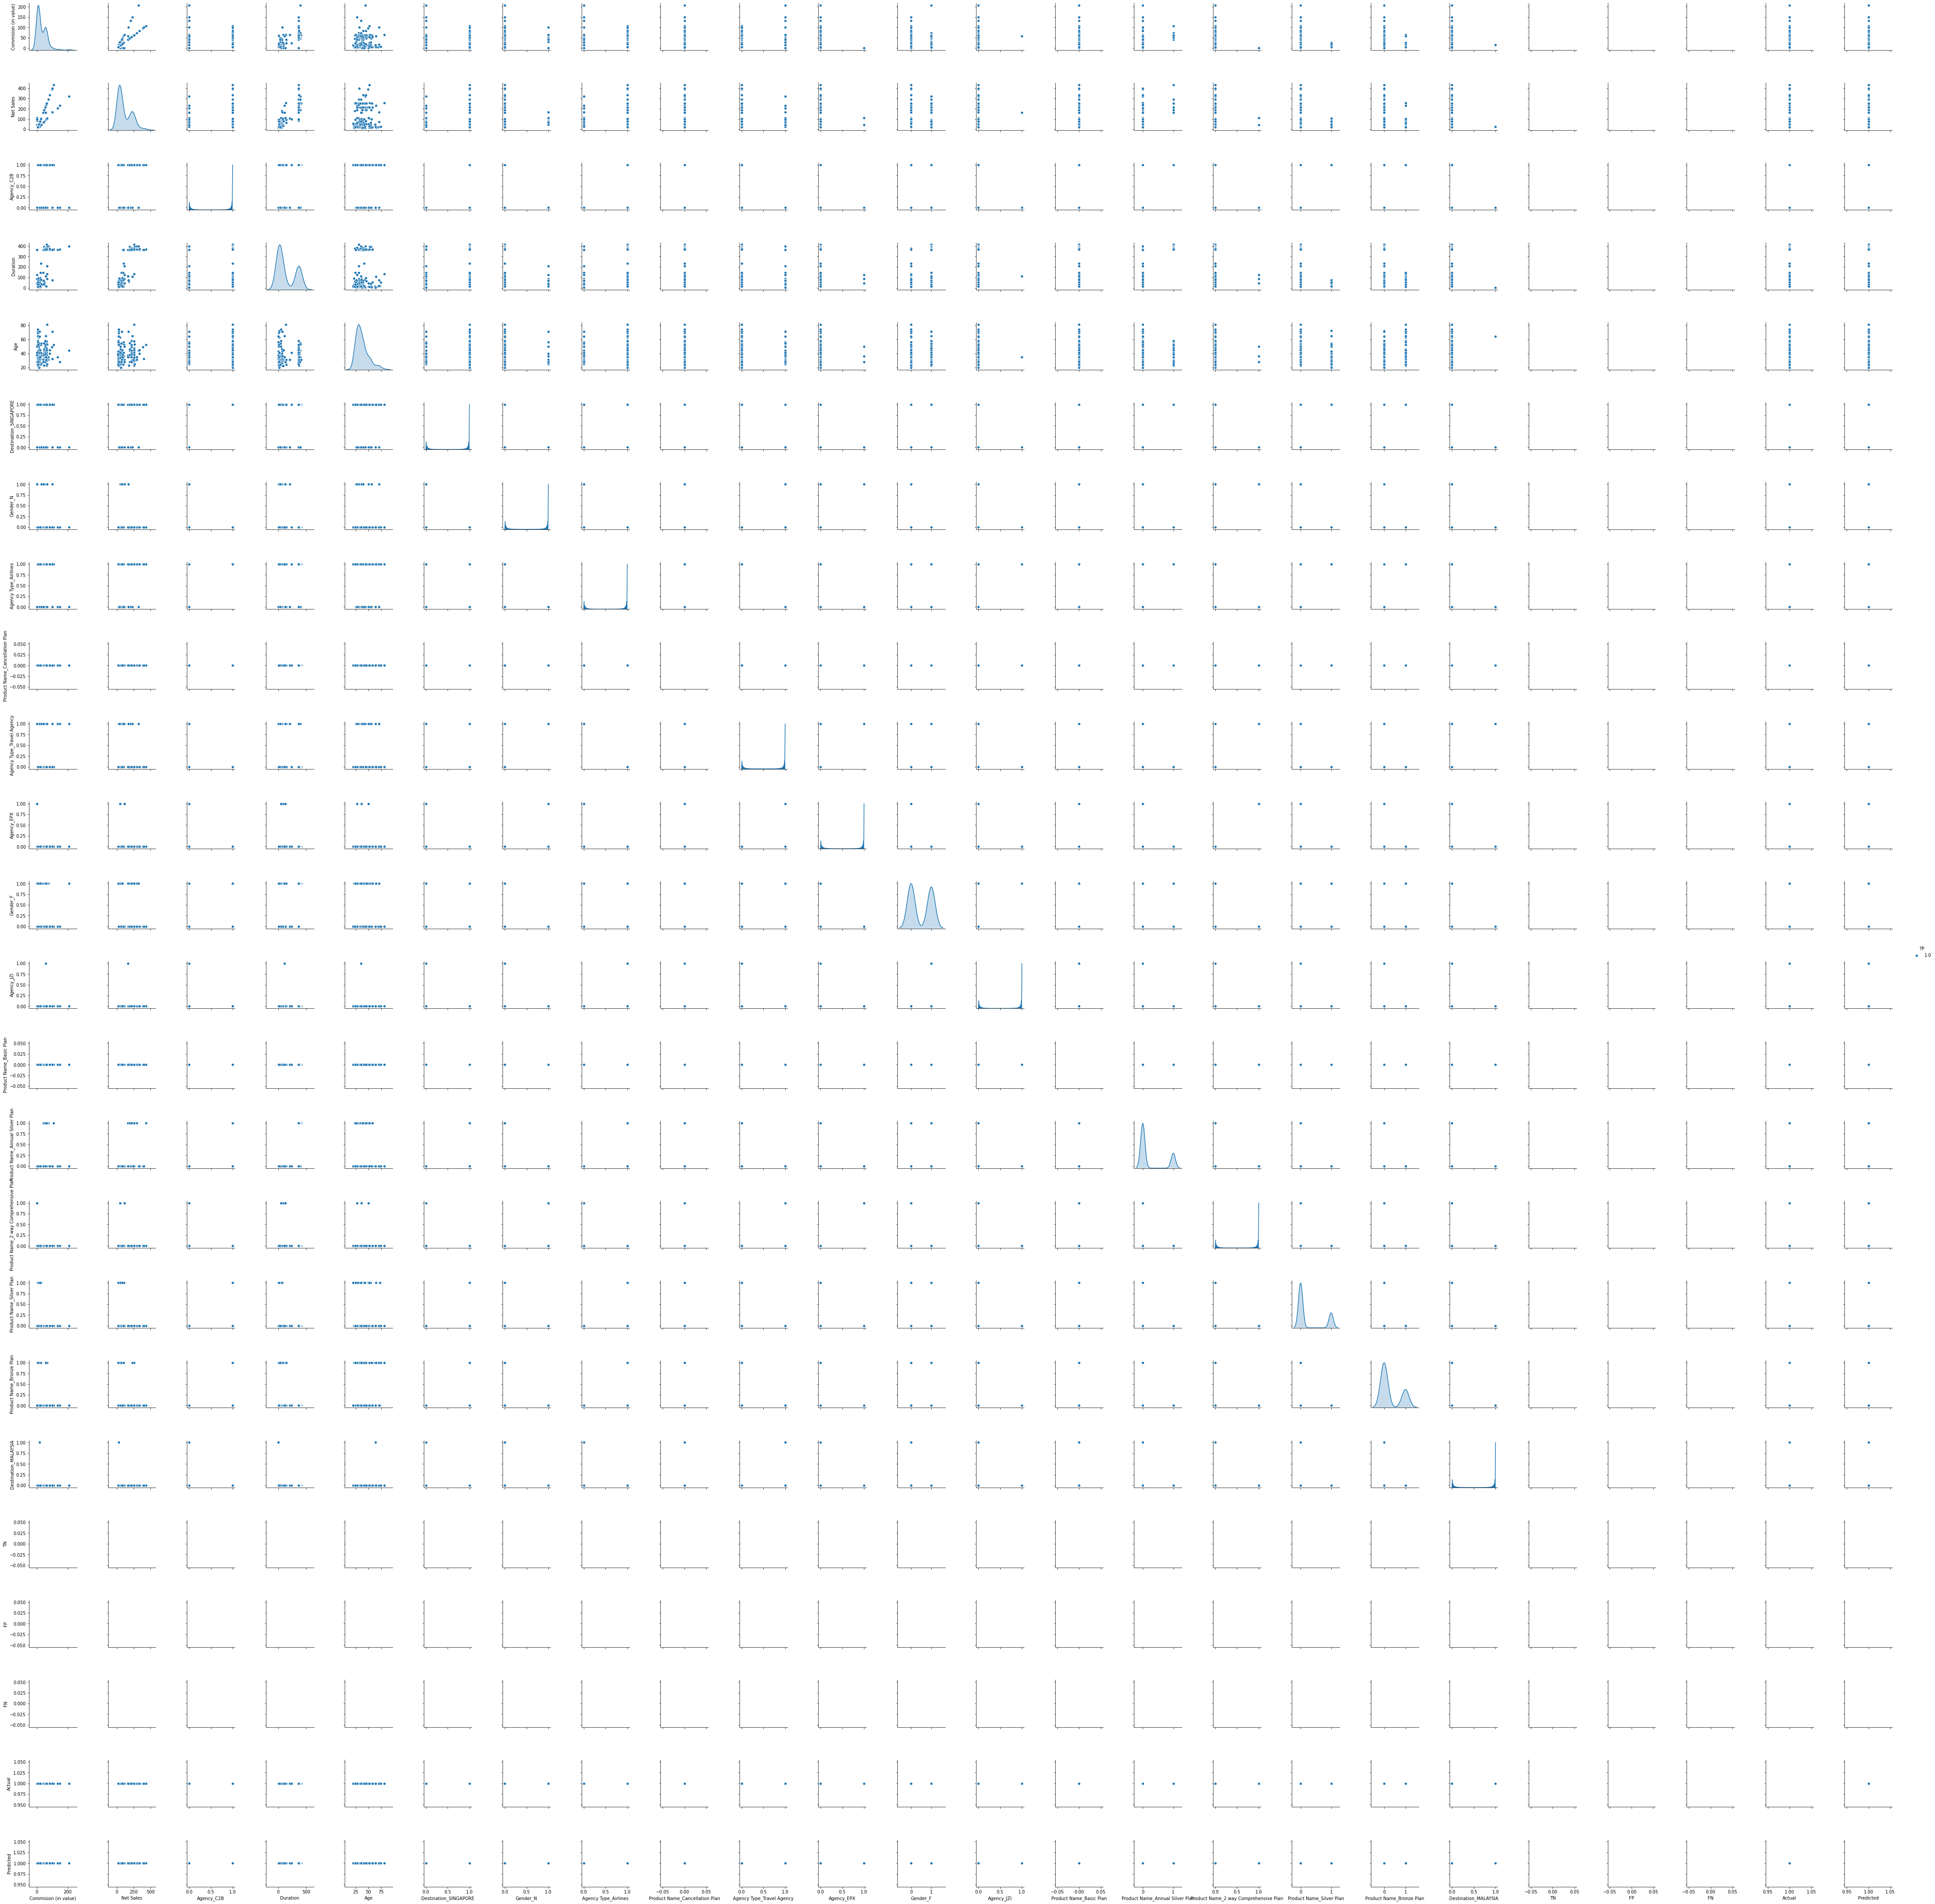

In [127]:
sns.pairplot(new_dff,hue='TP')

In [108]:
con=['TP','TN','FP','FN','Actual','Predicted','Commision (in value)', 'Net Sales','Duration','Age']
l_n=h2.copy()
for i in con:
  l_n.remove(i)

In [77]:
ll=iter(l_n)

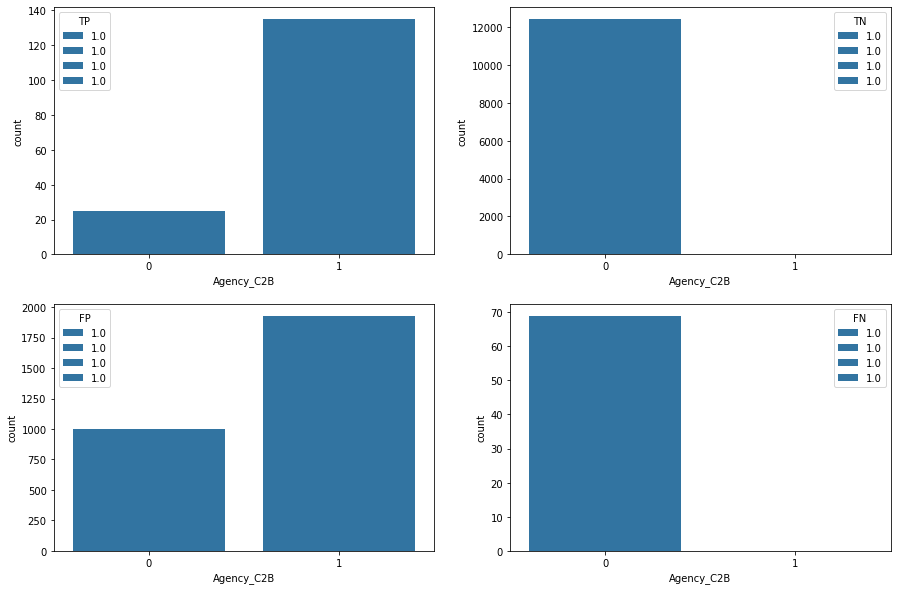

In [78]:
plot_buk(next(ll),new_dff)

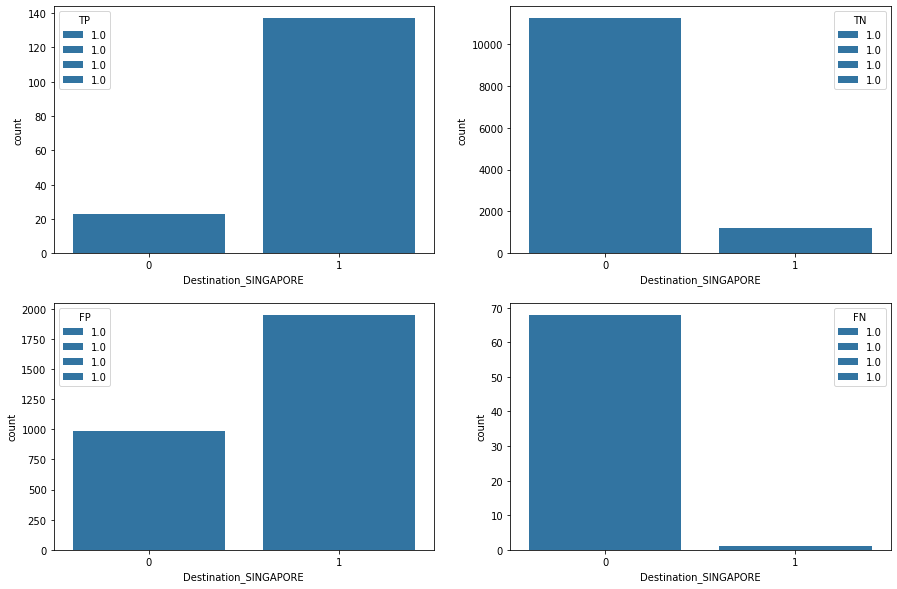

In [79]:
plot_buk(next(ll),new_dff)

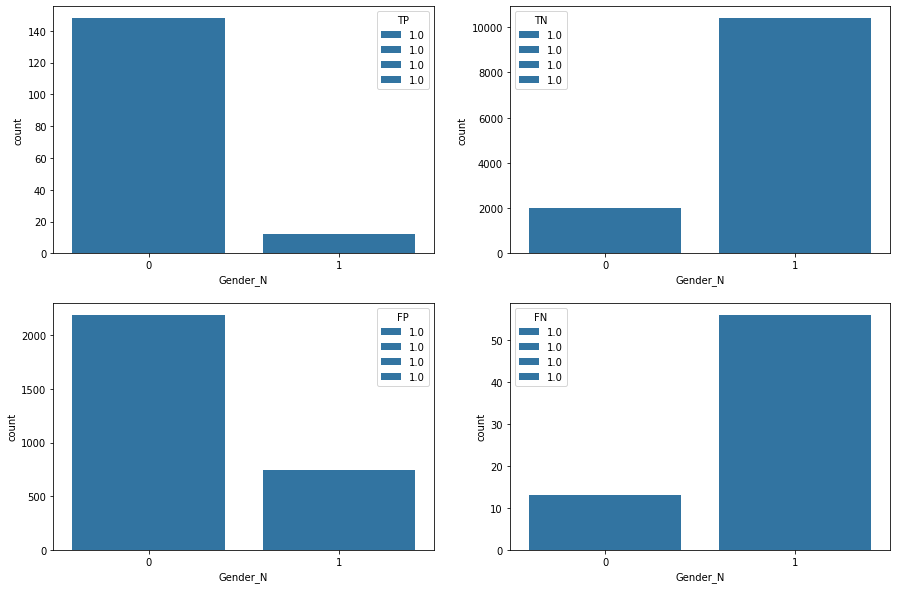

In [80]:
plot_buk(next(ll),new_dff)

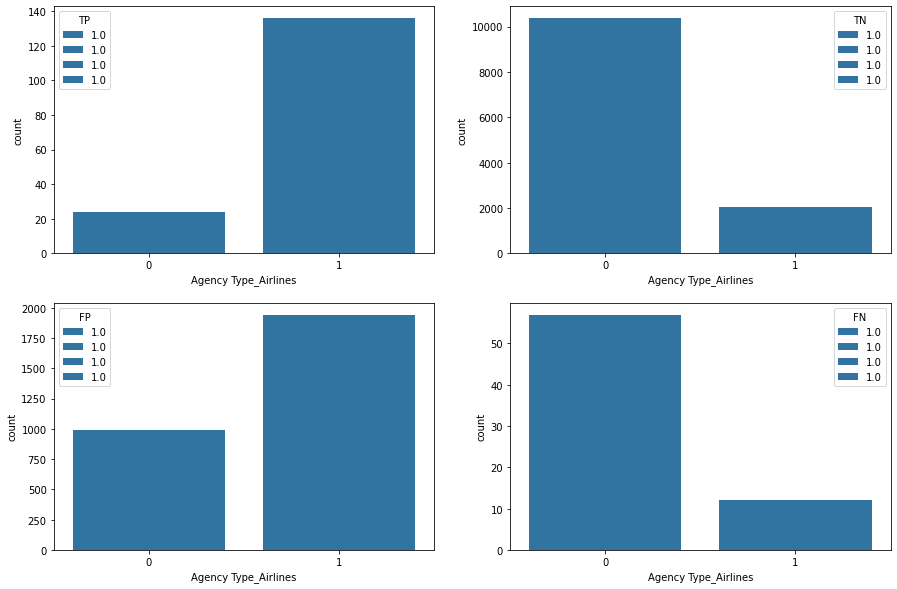

In [81]:
plot_buk(next(ll),new_dff)

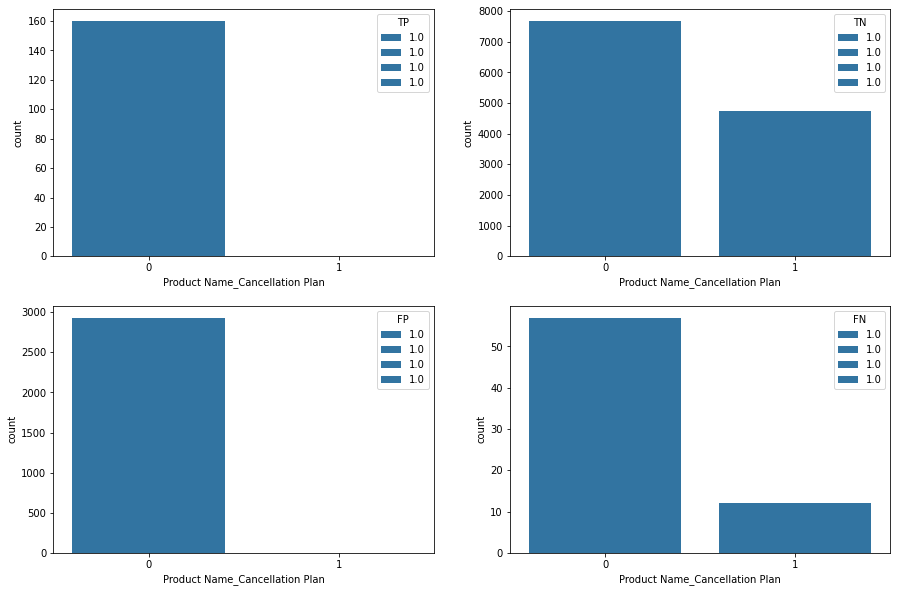

In [82]:
plot_buk(next(ll),new_dff)

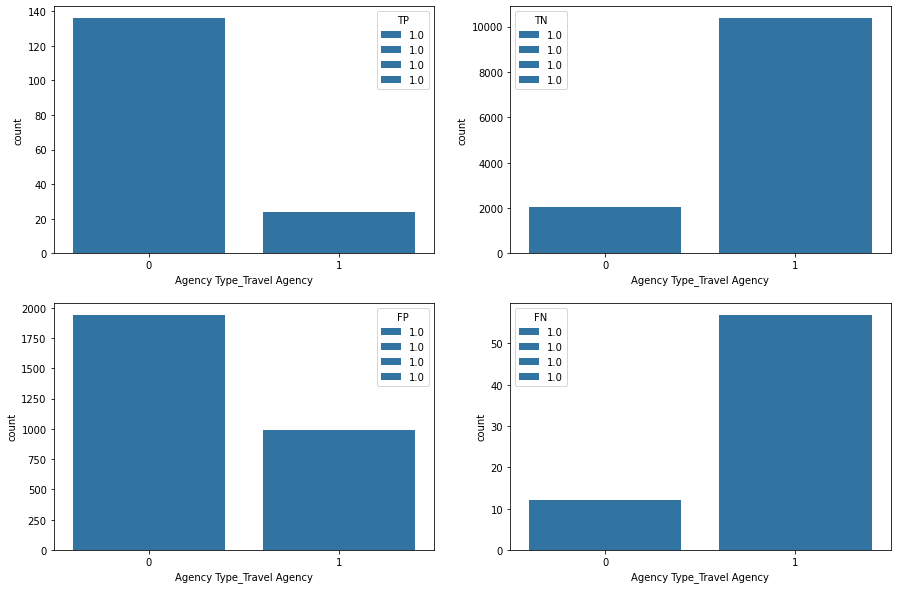

In [83]:
plot_buk(next(ll),new_dff)

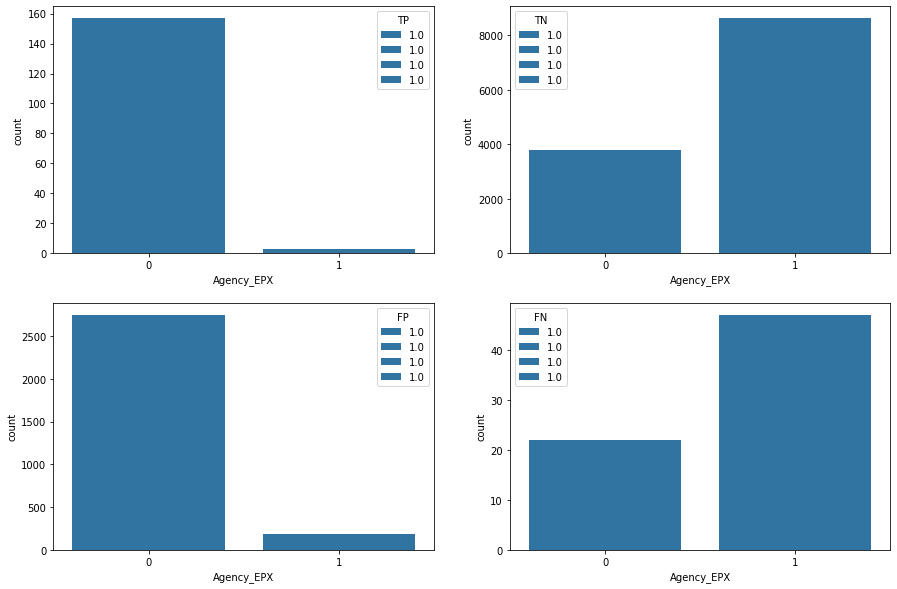

In [84]:
plot_buk(next(ll),new_dff)

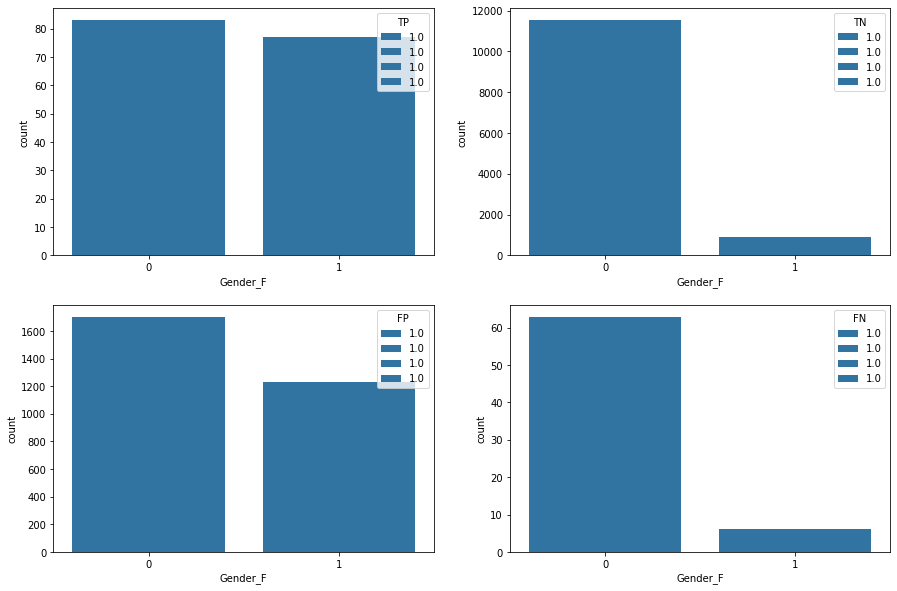

In [85]:
plot_buk(next(ll),new_dff)

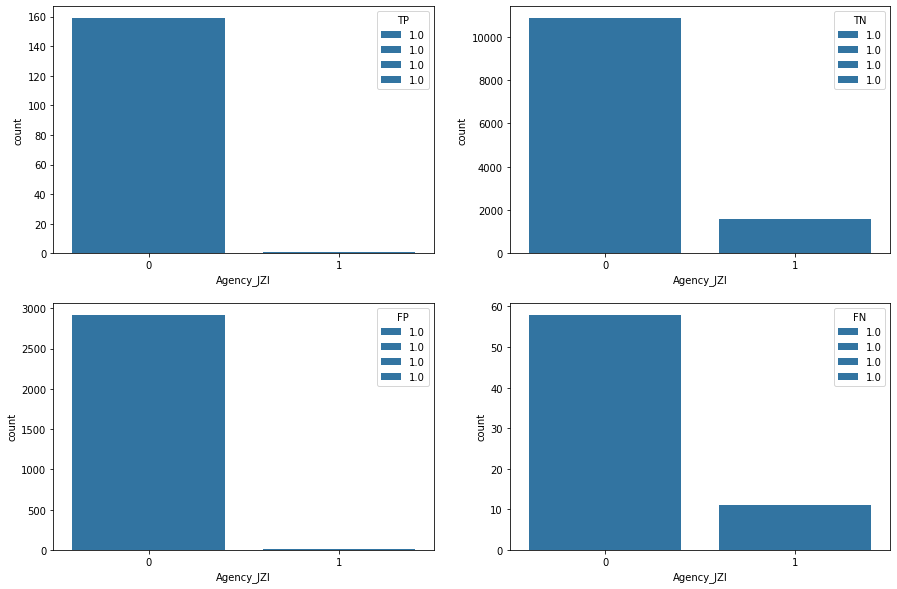

In [86]:
plot_buk(next(ll),new_dff)

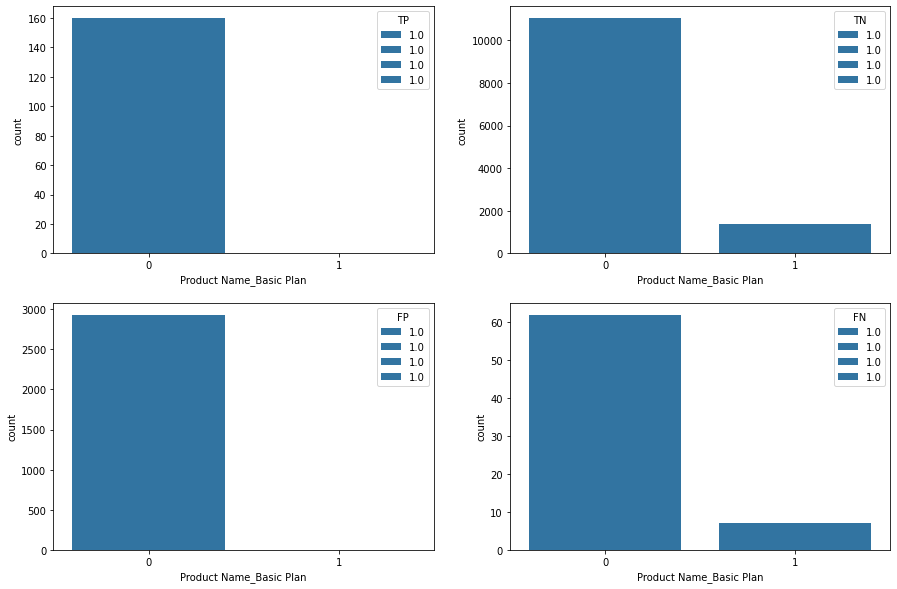

In [87]:
plot_buk(next(ll),new_dff)

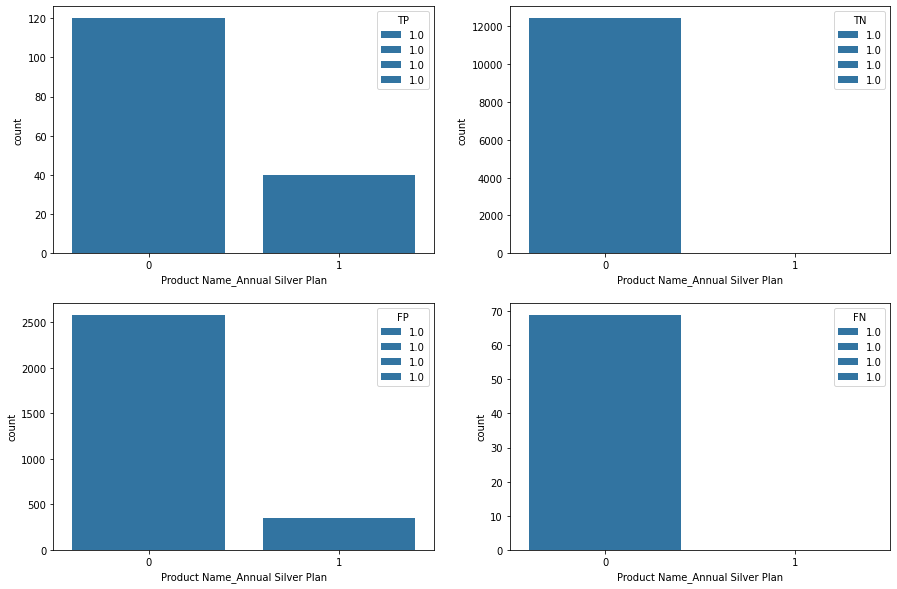

In [88]:
plot_buk(next(ll),new_dff)

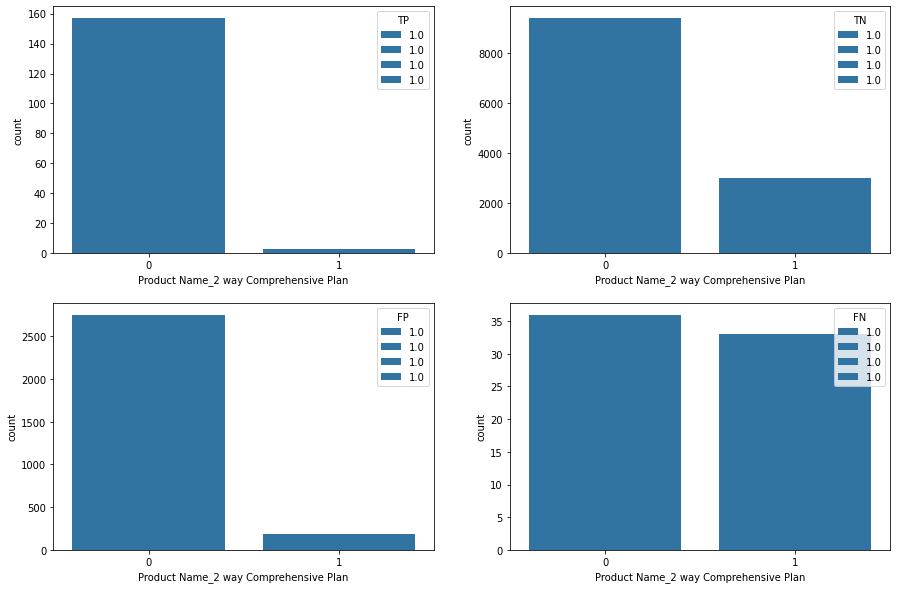

In [89]:
plot_buk(next(ll),new_dff)

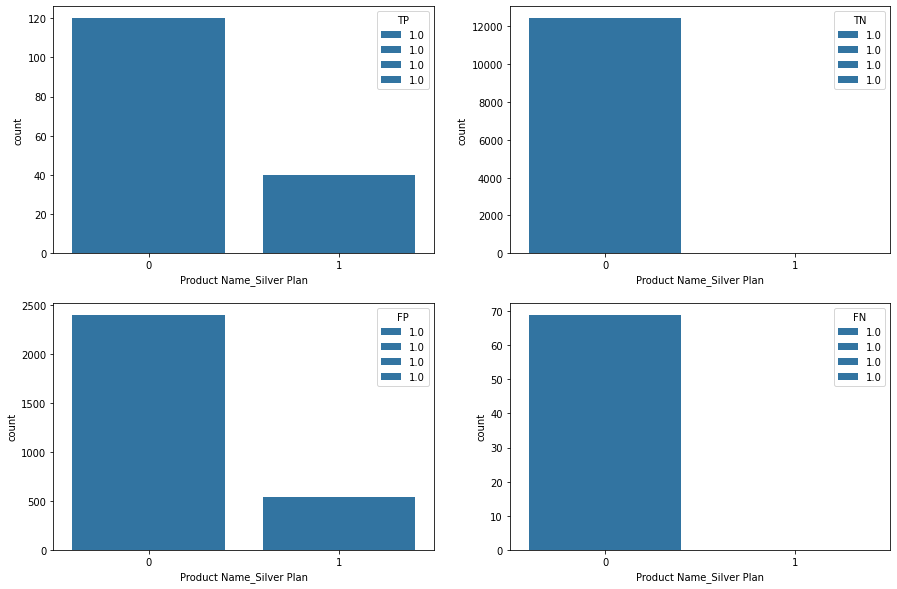

In [90]:
plot_buk(next(ll),new_dff)

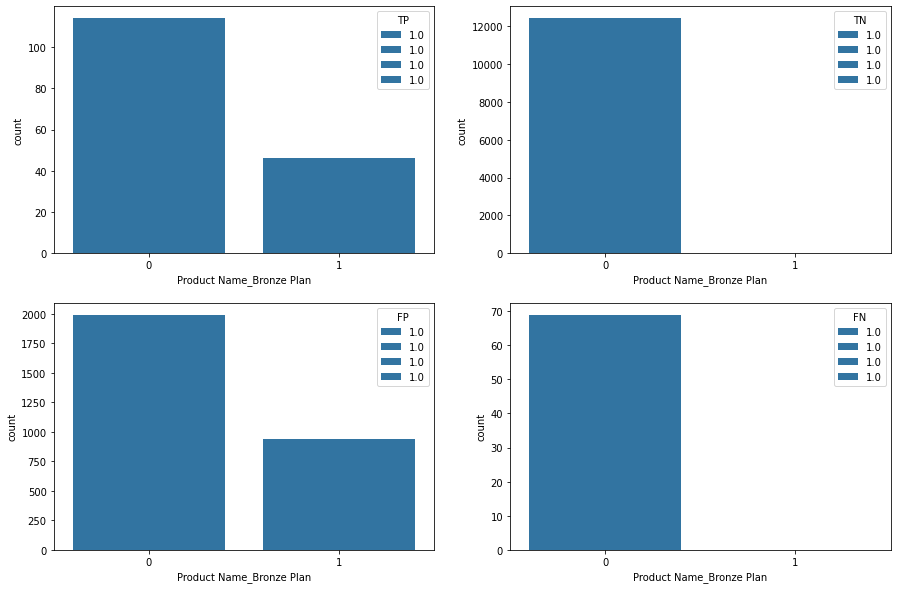

In [91]:
plot_buk(next(ll),new_dff)

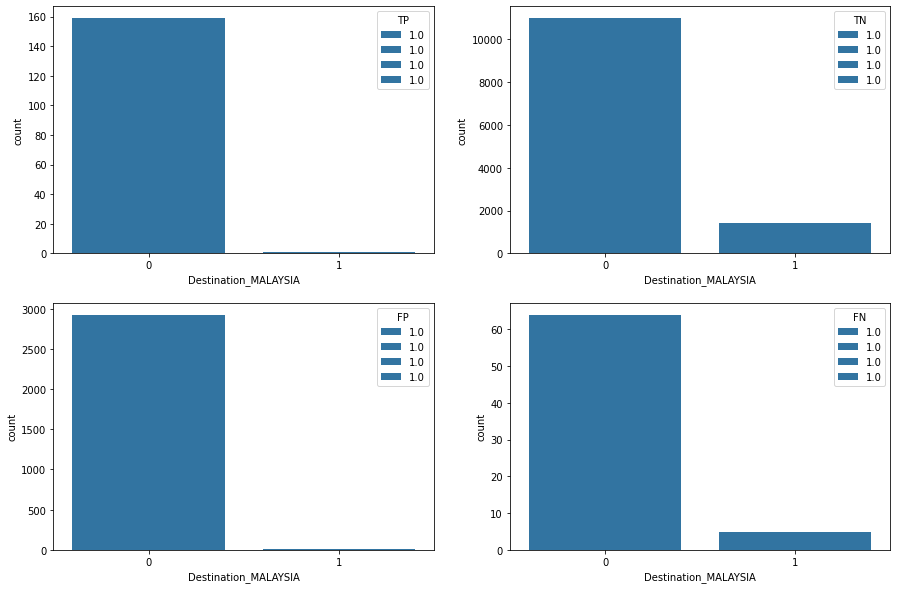

In [92]:
plot_buk(next(ll),new_dff)

### Without Hyperparameter tuning 

In [93]:
l

['Duration',
 'Net Sales',
 'Age',
 'Commision (in value)',
 'Agency_C2B',
 'Destination_SINGAPORE',
 'Product Name_Cancellation Plan',
 'Gender_N',
 'Agency_EPX',
 'Agency Type_Airlines',
 'Agency Type_Travel Agency',
 'Agency_JZI',
 'Destination_CHINA',
 'Product Name_Bronze Plan',
 'Product Name_2 way Comprehensive Plan',
 'Gender_M',
 'Product Name_Annual Silver Plan',
 'Gender_F',
 'Destination_THAILAND']

In [94]:
new_=comp_feat(X_test,y_test,y_pred)

In [95]:
for i in n:
  l.append(i)
new_=new_[l]

In [96]:
new_

,Duration,Net Sales,Age,Commision (in value),Agency_C2B,Destination_SINGAPORE,Product Name_Cancellation Plan,Gender_N,Agency_EPX,Agency Type_Airlines,Agency Type_Travel Agency,Agency_JZI,Destination_CHINA,Product Name_Bronze Plan,Product Name_2 way Comprehensive Plan,Gender_M,Product Name_Annual Silver Plan,Gender_F,Destination_THAILAND,TP,TN,FP,FN,Actual,Predicted
0,21,20.0,34,0.00,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0,0
1,47,24.0,36,0.00,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0,0
2,61,-59.4,60,35.64,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
3,63,80.0,36,0.00,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
4,79,28.0,36,0.00,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15581,77,29.0,36,0.00,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0,0
15582,4,15.0,36,0.00,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
15583,40,26.0,44,9.10,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0,0
15584,35,72.0,39,18.00,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,0,1


# Threshold

In [97]:
x=np.linspace(0.5,0.95,10)
x

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [98]:
# cv=3
y_prob_hy = clf_best_dt.predict_proba(X_test)
y_prob_hy

array([[0.6951751 , 0.3048249 ],
       [0.7524644 , 0.2475356 ],
       [0.6885838 , 0.3114162 ],
       ...,
       [0.72375533, 0.27624467],
       [0.20087667, 0.79912333],
       [0.82351068, 0.17648932]])

In [99]:
#cv=10
y_prob_hyp = clf_best_.predict_proba(X_test)
y_prob_hyp

array([[0.67208572, 0.32791428],
       [0.76297419, 0.23702581],
       [0.70571091, 0.29428909],
       ...,
       [0.73979914, 0.26020086],
       [0.1692489 , 0.8307511 ],
       [0.81760356, 0.18239644]])

In [100]:
# CV= 10
for i in x:
  print("\n Threshold => ",i,'\n')
  comp(y_test,thresh(y_prob_hyp,i))


 Threshold =>  0.5 

160 12423 2934 69
Confusion Matrix       : 
 [12423, 2934] 
 [69, 160]
Accuracy of Model      :  0.8073270884126781
Precision of Model     :  0.051712992889463474
Recall of Model        :  0.6986899563318777
F1 Score of Model      :  0.09629852542882937

 Threshold =>  0.55 

169 11855 3502 60
Confusion Matrix       : 
 [11855, 3502] 
 [60, 169]
Accuracy of Model      :  0.7714615680739125
Precision of Model     :  0.046036502315445385
Recall of Model        :  0.7379912663755459
F1 Score of Model      :  0.08666666666666667

 Threshold =>  0.6 

180 11157 4200 49
Confusion Matrix       : 
 [11157, 4200] 
 [49, 180]
Accuracy of Model      :  0.7273835493391505
Precision of Model     :  0.0410958904109589
Recall of Model        :  0.7860262008733624
F1 Score of Model      :  0.07810804946843132

 Threshold =>  0.65 

192 10244 5113 37
Confusion Matrix       : 
 [10244, 5113] 
 [37, 192]
Accuracy of Model      :  0.669575259848582
Precision of Model     :  0.0361922

In [101]:
# CV= 3
for i in x:
  print("\n Threshold => ",i,'\n')
  comp(y_test,thresh(y_prob_hy,i))


 Threshold =>  0.5 

160 12542 2815 69
Confusion Matrix       : 
 [12542, 2815] 
 [69, 160]
Accuracy of Model      :  0.814962145515206
Precision of Model     :  0.05378151260504202
Recall of Model        :  0.6986899563318777
F1 Score of Model      :  0.09987515605493133

 Threshold =>  0.55 

166 11937 3420 63
Confusion Matrix       : 
 [11937, 3420] 
 [63, 166]
Accuracy of Model      :  0.7765302194276915
Precision of Model     :  0.046291132180702736
Recall of Model        :  0.7248908296943232
F1 Score of Model      :  0.0870249017038008

 Threshold =>  0.6 

181 11204 4153 48
Confusion Matrix       : 
 [11204, 4153] 
 [48, 181]
Accuracy of Model      :  0.7304632362376492
Precision of Model     :  0.04176280572219659
Recall of Model        :  0.7903930131004366
F1 Score of Model      :  0.07933377164146395

 Threshold =>  0.65 

191 10215 5142 38
Confusion Matrix       : 
 [10215, 5142] 
 [38, 191]
Accuracy of Model      :  0.6676504555370204
Precision of Model     :  0.03581473

In [102]:
y_prob=clf_dt.predict_proba(X_test)
y_prob

array([[0.67      , 0.33      ],
       [0.91      , 0.09      ],
       [0.80333333, 0.19666667],
       ...,
       [0.79      , 0.21      ],
       [0.28      , 0.72      ],
       [0.88      , 0.12      ]])

In [103]:
# Without hyperparameter tuning 
for i in x:
  print("\n Threshold => ",i,'\n')
  comp(y_test,thresh(y_prob,i))


 Threshold =>  0.5 

171 11424 3933 58
Confusion Matrix       : 
 [11424, 3933] 
 [58, 171]
Accuracy of Model      :  0.7439368664185808
Precision of Model     :  0.041666666666666664
Recall of Model        :  0.7467248908296943
F1 Score of Model      :  0.07892914839603046

 Threshold =>  0.55 

173 10939 4418 56
Confusion Matrix       : 
 [10939, 4418] 
 [56, 173]
Accuracy of Model      :  0.7129475170024381
Precision of Model     :  0.03768242213025485
Recall of Model        :  0.7554585152838428
F1 Score of Model      :  0.07178423236514524

 Threshold =>  0.6 

182 10341 5016 47
Confusion Matrix       : 
 [10341, 5016] 
 [47, 182]
Accuracy of Model      :  0.6751571923521109
Precision of Model     :  0.03501346671796845
Recall of Model        :  0.7947598253275109
F1 Score of Model      :  0.06707204717154966

 Threshold =>  0.65 

192 9728 5629 37
Confusion Matrix       : 
 [9728, 5629] 
 [37, 192]
Accuracy of Model      :  0.6364686256897215
Precision of Model     :  0.03298402